<a href="https://colab.research.google.com/github/sayandas96476/gemstone-identification-using-deep-learning-approach/blob/main/DenseNet%20201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import all libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import copy
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

!unzip -u /content/drive/MyDrive/train.zip -d /content
!unzip -u /content/drive/MyDrive/test.zip -d /content

Archive:  /content/drive/MyDrive/train.zip
Archive:  /content/drive/MyDrive/test.zip


In [ ]:
train_path = '/content/train'
test_path = '/content/test'
BATCH_SIZE = 64
IMG_SIZE = 224 
seed=123
input_shape = (IMG_SIZE,IMG_SIZE)

valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,\
rotation_range=15, shear_range=10,\
zoom_range=0.1, fill_mode='nearest', \
height_shift_range=0.05, width_shift_range=0.1)

In [ ]:

valid_gen = valid_datagen.flow_from_directory(directory=train_path,subset='validation',
                                              target_size=input_shape,
                                              color_mode='rgb',
                                              classes=None,
                                              class_mode='categorical',
                                              batch_size=BATCH_SIZE,
                                              shuffle=False,
                                              seed=seed,
                                              save_to_dir=None,
                                              save_prefix='',
                                              save_format='png',
                                              follow_links=False,
                                              interpolation='nearest')


train_gen = train_datagen.flow_from_directory(subset='training',
                                              directory=train_path,
                                              target_size=input_shape,
                                              color_mode='rgb',
                                              classes=None,
                                              class_mode='categorical',
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              seed=seed,
                                              save_to_dir=None,
                                              save_prefix='',
                                              save_format='png',
                                              follow_links=False,
                                              interpolation='nearest')

Found 543 images belonging to 87 classes.
Found 2313 images belonging to 87 classes.


Number of images:  2313


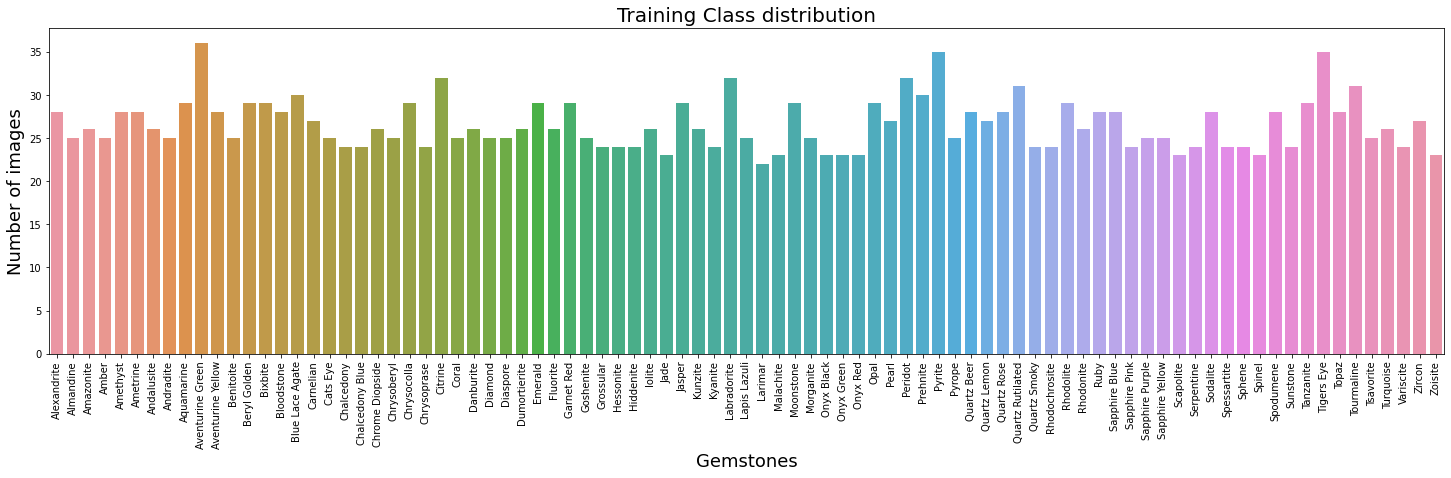

In [ ]:
n_classes=87
class_indices = train_gen.class_indices
temp_df = pd.DataFrame({'class': train_gen.classes}).value_counts().reset_index().sort_values(by='class')
temp_df.columns = ['class', 'counts']
plt.figure(figsize=(25,6))
sns.barplot(data=temp_df,
x='class',
y='counts')
plt.ylabel('Number of images', fontsize=18)
plt.xlabel('Gemstones', fontsize=18)
plt.title('Training Class distribution', fontsize=20)
plt.xticks(np.arange(len(class_indices)), labels=class_indices.keys(), rotation=90)
print('Number of images: ', np.sum(temp_df['counts'].values))


In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:
# img_dim = np.reshape(input_shape, (224,224,1))

In [ ]:
densenet = DenseNet201(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False, pooling='max')

74850304/74836368 [==============================] - 1s 0us/step


In [ ]:
# freeze the weights
for layer in densenet.layers:
  layer.trainable=False

# add custom layers to the architecture
x = Flatten()(densenet.output)
prediction = Dense(n_classes, activation='softmax')(x)

In [ ]:
model = Model(inputs=densenet.input, outputs = prediction)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
# compile the model
from keras.metrics import TopKCategoricalAccuracy
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',
              TopKCategoricalAccuracy(3, "top-3 accuracy"), 
              TopKCategoricalAccuracy(5, "top-5 accuracy")])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,EarlyStopping

checkpoint_path = "/content/drive/MyDrive/densenet201/weights.ckpt"

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)
#Early Stopping
earlystopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    verbose=0,
    mode='min')

history_cb = CSVLogger('/content/drive/MyDrive/densenet201/log.csv', separator=",", append=False)

In [ ]:
r = model.fit(train_gen,
             validation_data=valid_gen,
             epochs=10,
             callbacks=[history_cb,earlystopping_cb,cp_callback])

Epoch 1/10
37/37 [==============================] - ETA: 0s - loss: 5.5142 - accuracy: 0.0934 - top-3 accuracy: 0.1846 - top-5 accuracy: 0.2516
Epoch 1: val_accuracy improved from -inf to 0.18785, saving model to /content/drive/MyDrive/densenet201/weights.ckpt
37/37 [==============================] - 49s 862ms/step - loss: 5.5142 - accuracy: 0.0934 - top-3 accuracy: 0.1846 - top-5 accuracy: 0.2516 - val_loss: 3.9776 - val_accuracy: 0.1878 - val_top-3 accuracy: 0.3149 - val_top-5 accuracy: 0.4144
Epoch 2/10
37/37 [==============================] - ETA: 0s - loss: 2.3435 - accuracy: 0.4107 - top-3 accuracy: 0.6118 - top-5 accuracy: 0.7090
Epoch 2: val_accuracy improved from 0.18785 to 0.34438, saving model to /content/drive/MyDrive/densenet201/weights.ckpt
37/37 [==============================] - 28s 762ms/step - loss: 2.3435 - accuracy: 0.4107 - top-3 accuracy: 0.6118 - top-5 accuracy: 0.7090 - val_loss: 2.8518 - val_accuracy: 0.3444 - val_top-3 accuracy: 0.5525 - val_top-5 accuracy: 0.

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(directory=test_path,
                                            target_size = (224, 224),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical')

Found 363 images belonging to 87 classes.


In [ ]:
checkpoint_path = "/content/drive/MyDrive/densenet201/weights.ckpt"
model.load_weights(checkpoint_path)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',
              TopKCategoricalAccuracy(3, "top-3 accuracy"), 
              TopKCategoricalAccuracy(5, "top-5 accuracy")])
loss, acc, top3_acc, top5_acc = model.evaluate(test_set)
print("Restored model from checkpoint, accuracy: {:5.2f}%".format(100 * acc))
print("top 3_accuracy= , top 5_accuracy=",top3_acc, top5_acc)

6/6 [==============================] - 23s 882ms/step - loss: 1.4633 - accuracy: 0.6006 - top-3 accuracy: 0.8044 - top-5 accuracy: 0.8926
Restored model from checkpoint, accuracy: 60.06%
top 3_accuracy= , top 5_accuracy= 0.8044077157974243 0.8925619721412659


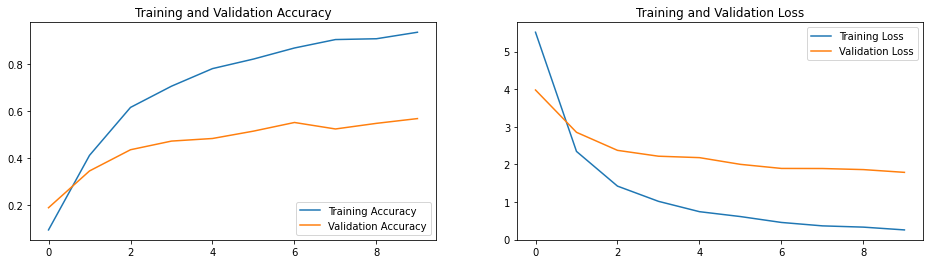

In [ ]:
acc = r.history['accuracy']
val_acc = r.history['val_accuracy']
loss = r.history['loss'] 
val_loss = r.history['val_loss'] 
plt.figure(figsize=(16, 4)) 
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy') 
plt.plot(val_acc, label='Validation Accuracy') 
plt.legend(loc='lower right') 
plt.title('Training and Validation Accuracy') 
plt.subplot(1, 2, 2) 
plt.plot(loss, label='Training Loss') 
plt.plot(val_loss, label='Validation Loss') 
plt.legend(loc='upper right') 
plt.title('Training and Validation Loss') 
plt.show()

In [ ]:
def plot_confusion_matrix(data_gen, title=''):
    n_batches = int(np.ceil(data_gen.n/BATCH_SIZE))
    classes_df = pd.DataFrame()

    for batch in np.arange(n_batches):
        classes = np.argmax(data_gen[batch][1], axis=1)
        temp_df = pd.DataFrame(classes)
        classes_df = classes_df.append(temp_df, ignore_index=True)
    classes_df.columns = ['true_class']

    #logits and probs
    logits = model.predict(data_gen)
    probs = tf.keras.activations.softmax(tf.constant(logits)).numpy()

    classes_df['predicted_class'] = np.argmax(probs, axis=1)
    
    conf_matrix = confusion_matrix(classes_df.true_class.values, 
                                    classes_df.predicted_class.values, 
                                    labels=np.arange(n_classes))
    conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)
    
    plt.figure(figsize=(40,30))
    sns.heatmap(conf_matrix_norm, 
                cmap='viridis',
                annot=conf_matrix_norm,
                vmin=0, vmax=1,)
    _ = plt.title(title, fontsize=25)
    _ = plt.yticks(np.arange(len(class_indices)), labels=class_indices.keys(), rotation=0)
    _ = plt.xticks(np.arange(len(class_indices)), labels=class_indices.keys(), rotation=90)

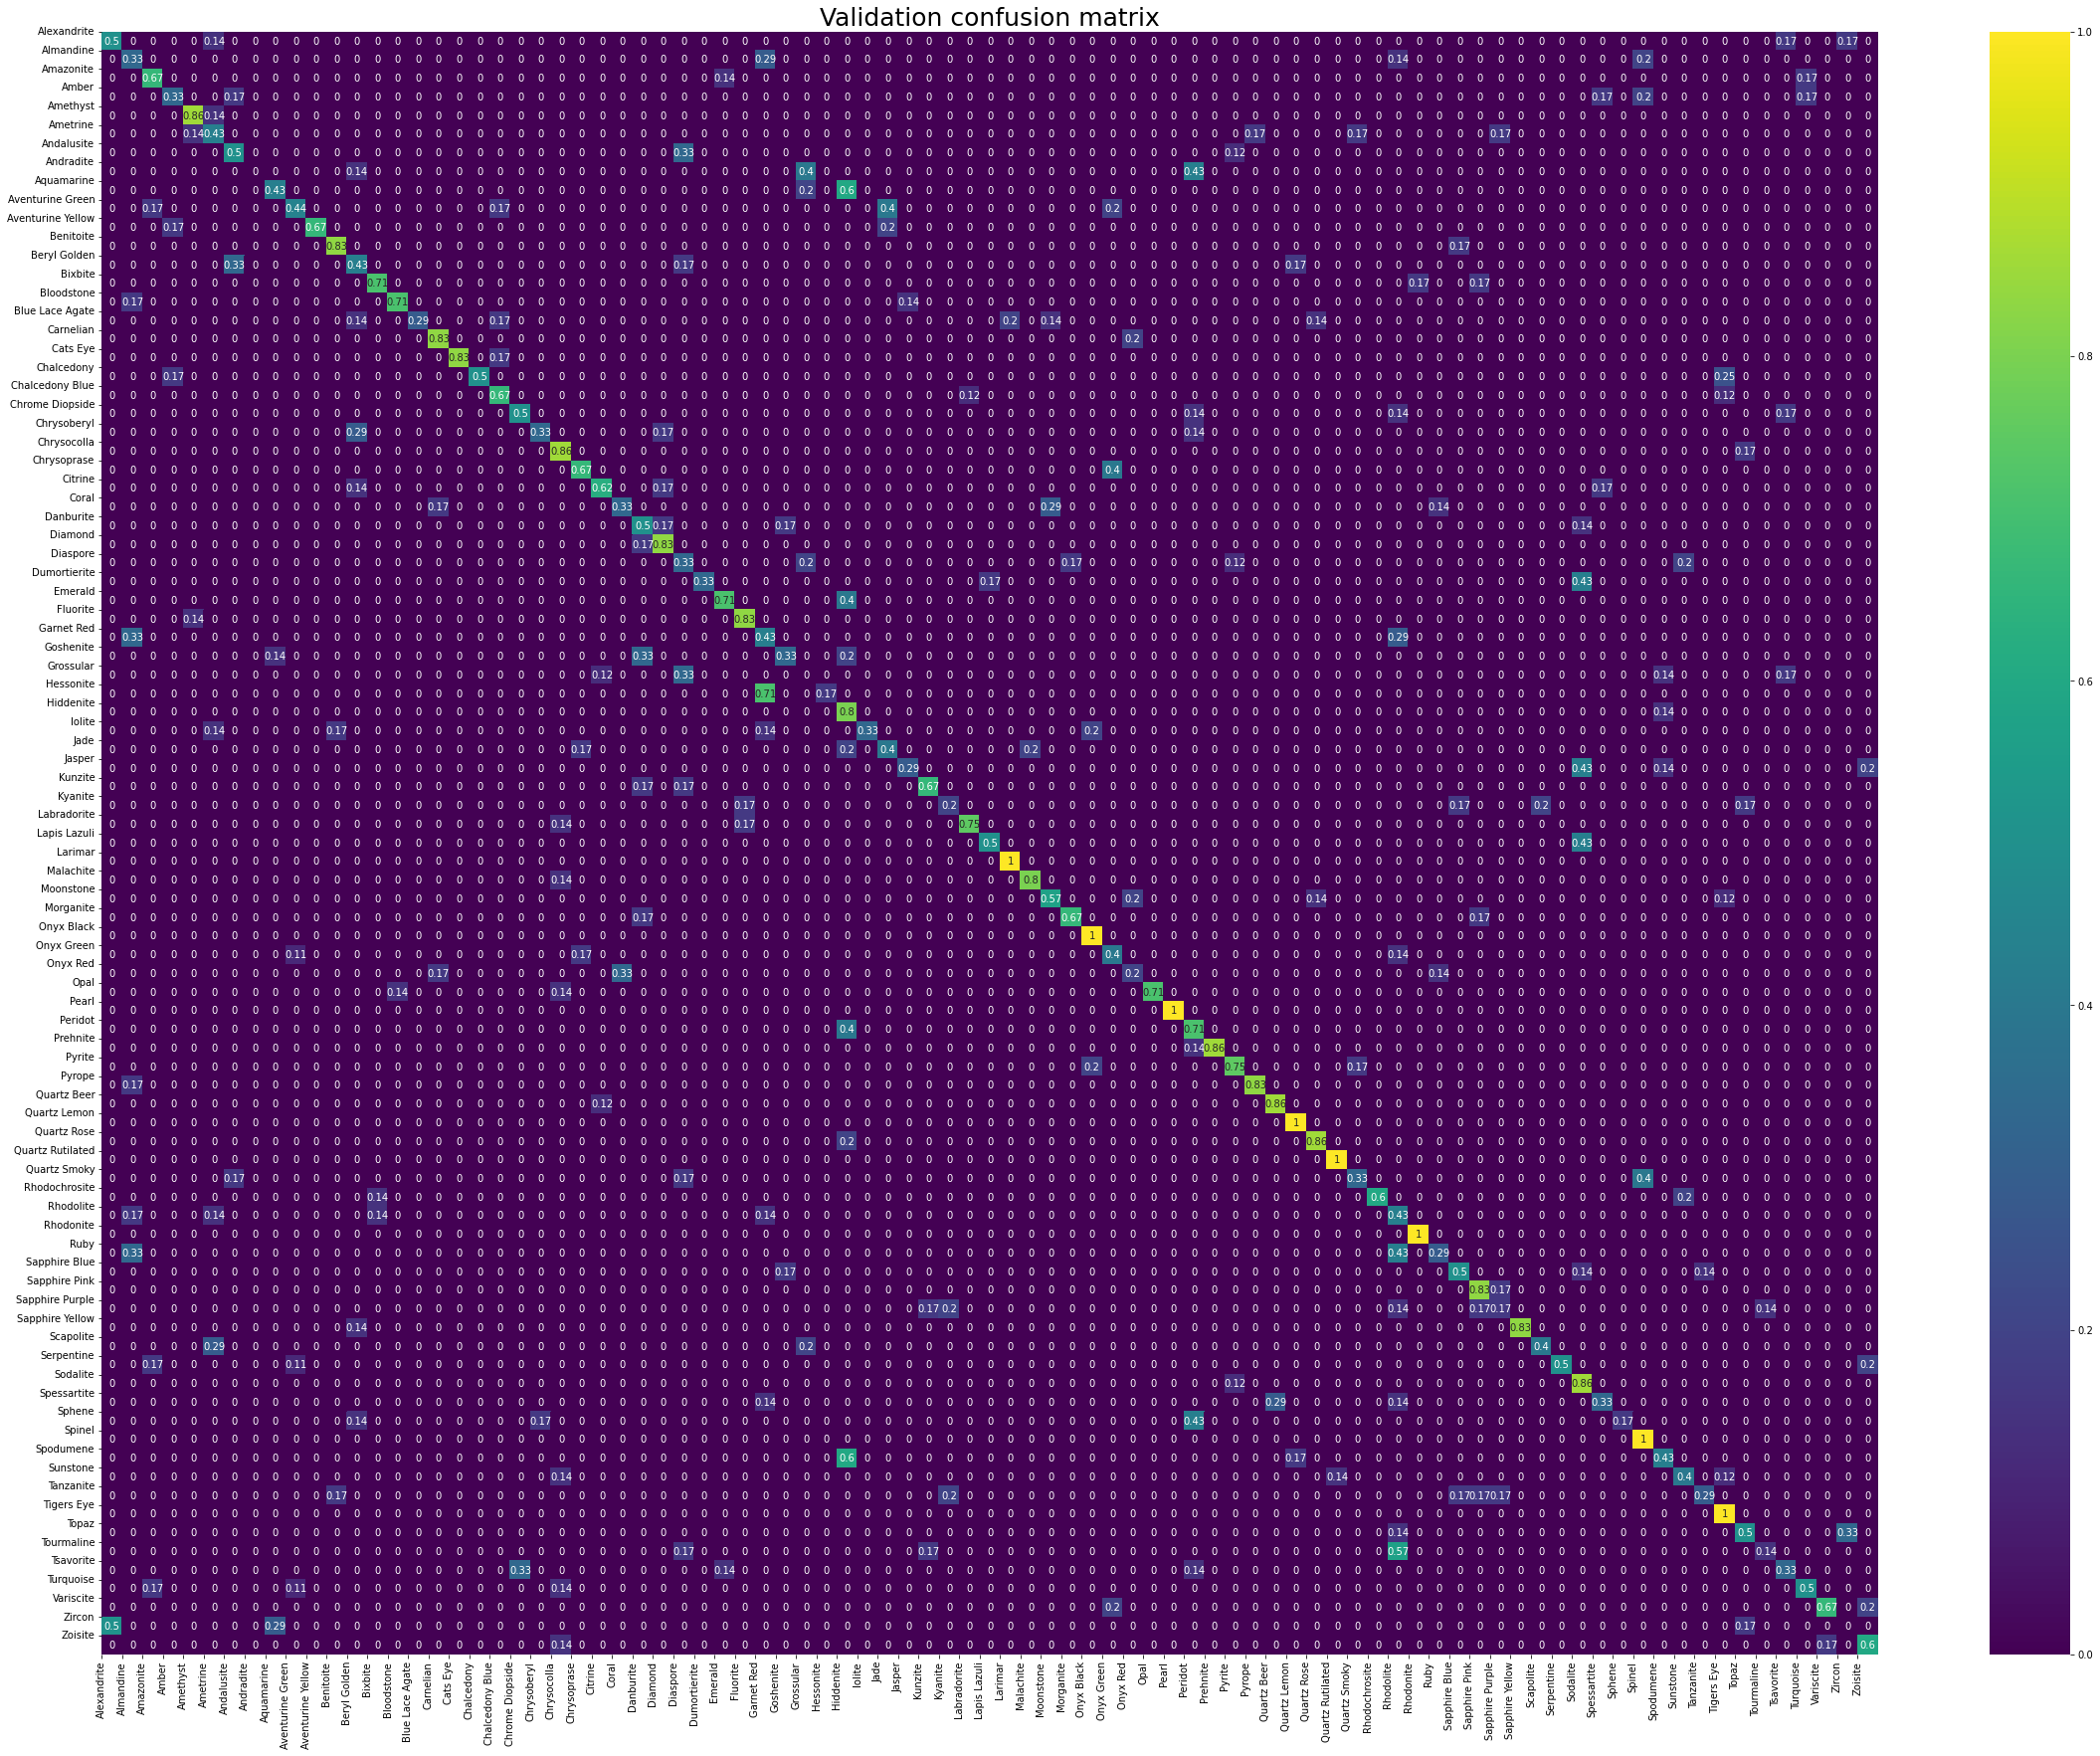

In [ ]:
plot_confusion_matrix(valid_gen, 'Validation confusion matrix')

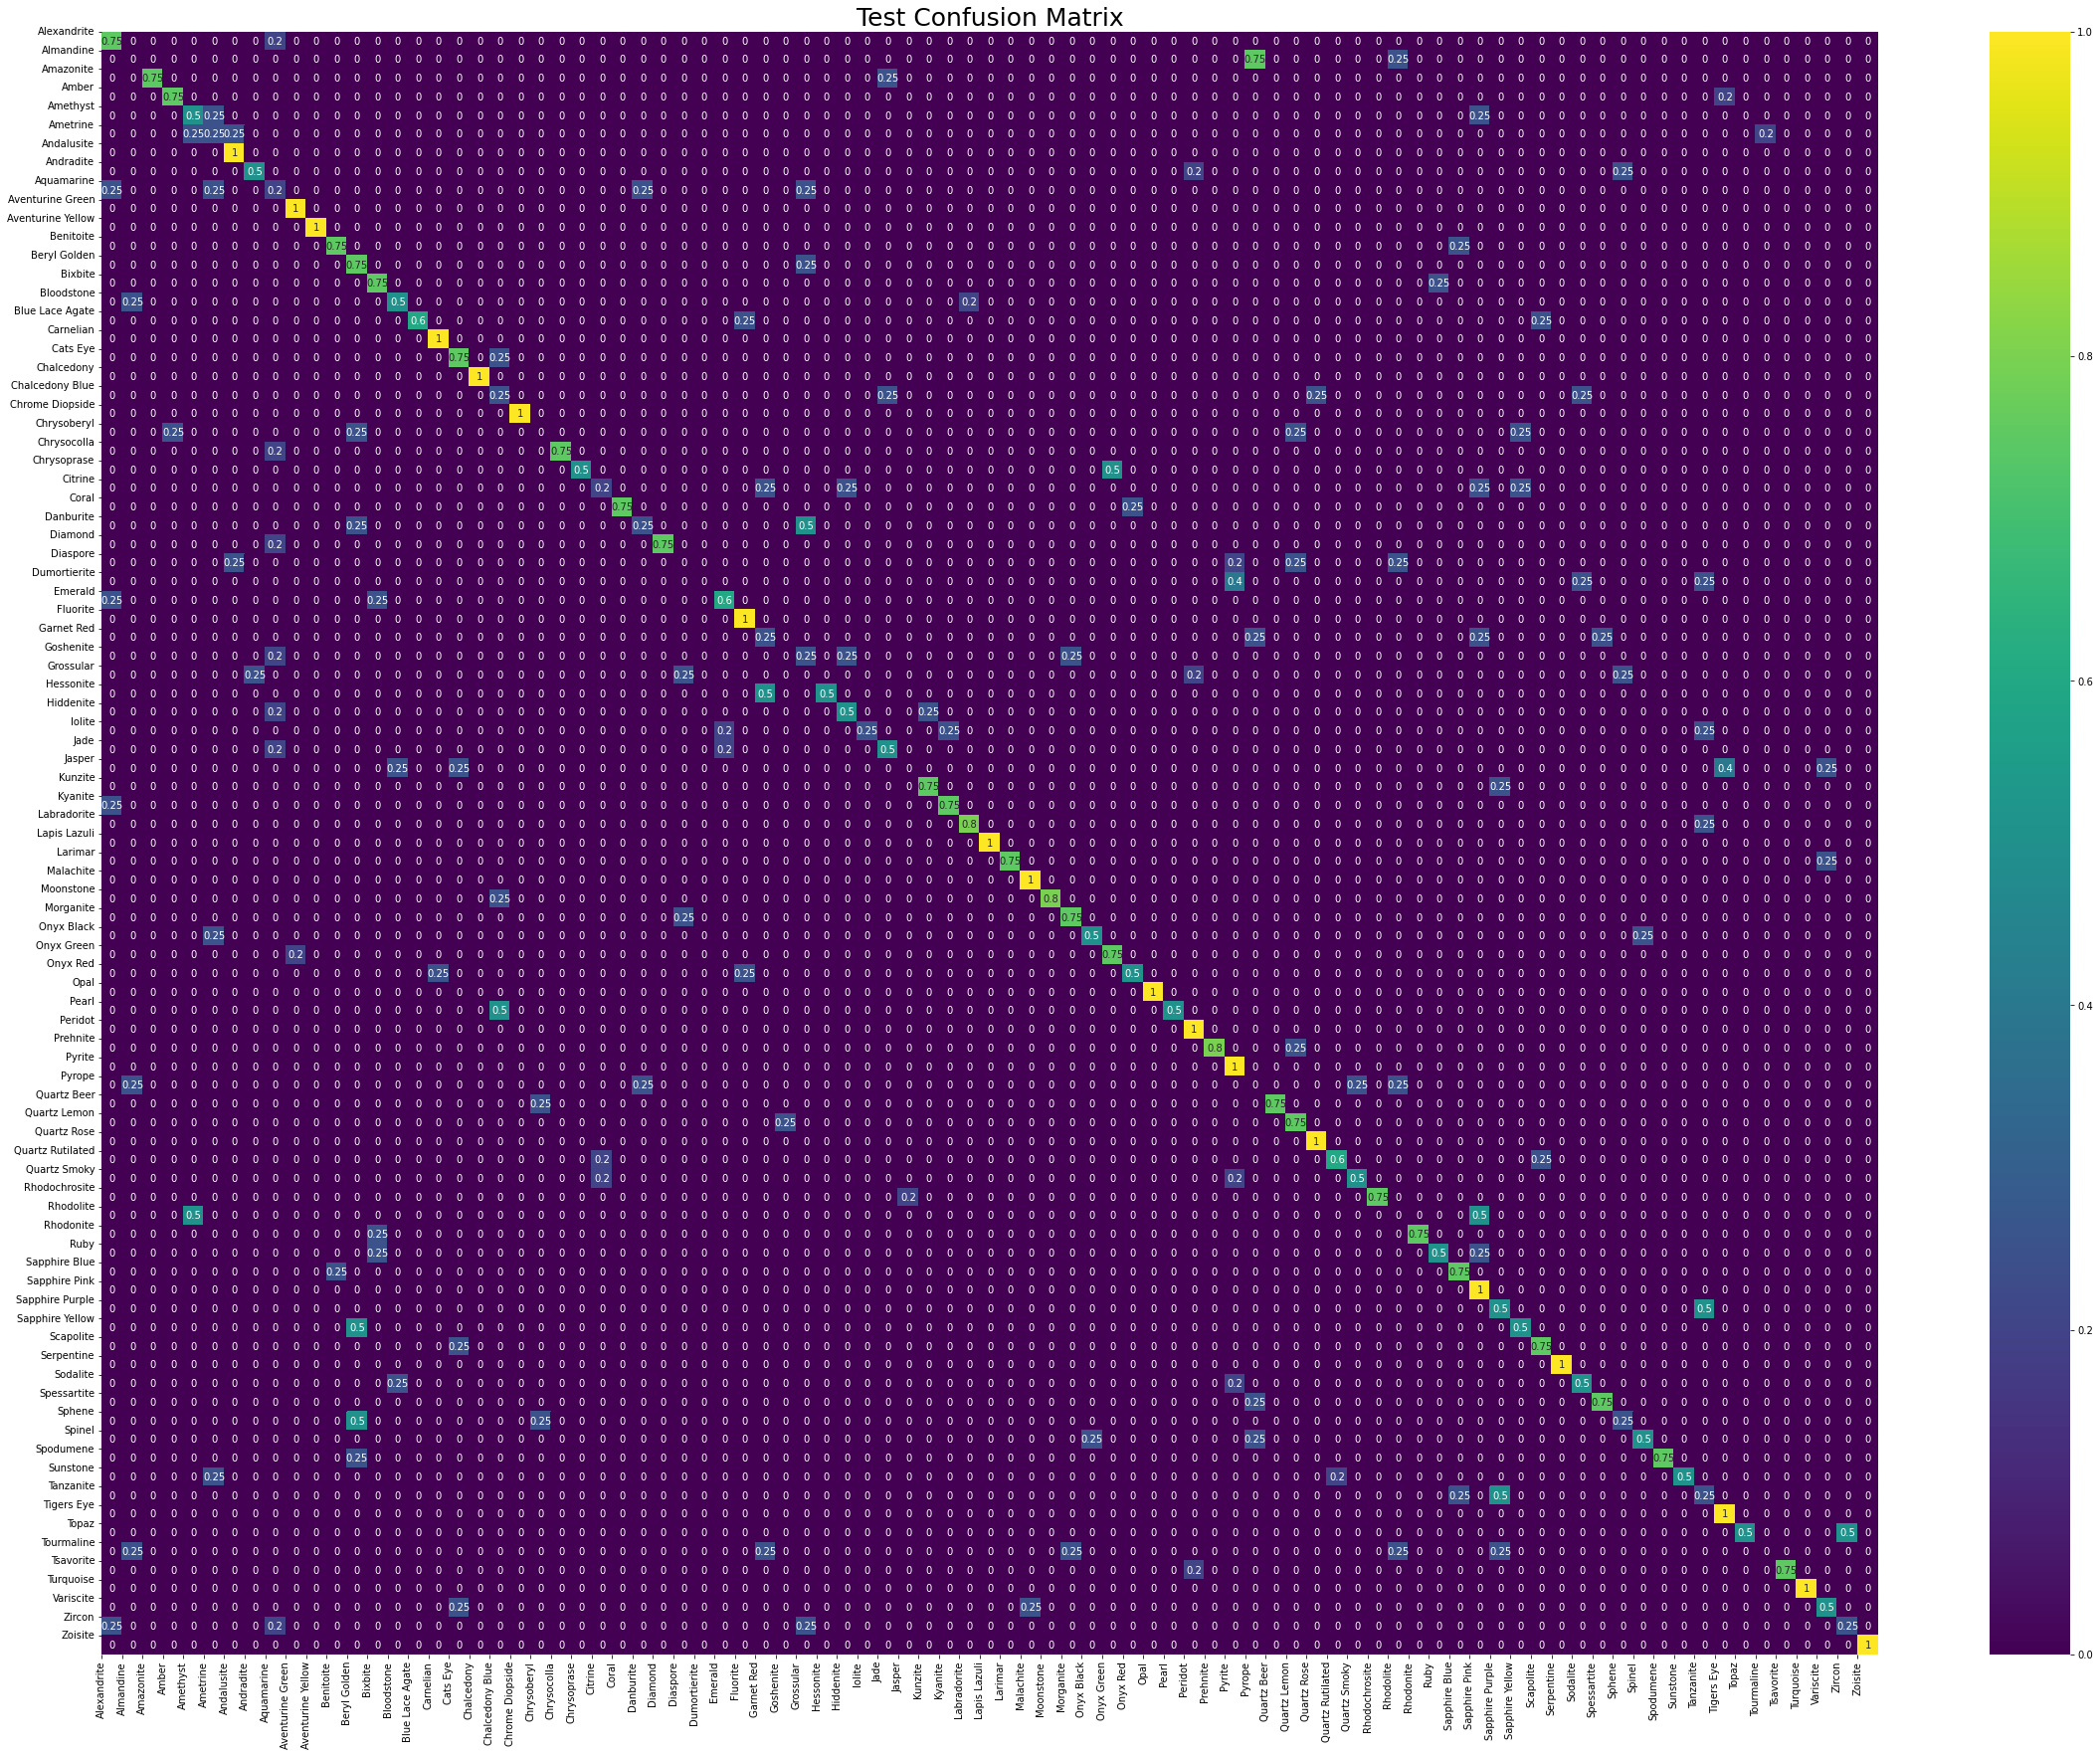

In [ ]:
plot_confusion_matrix(test_set,'Test Confusion Matrix')

In [ ]:
n_batches = int(np.ceil(test_set.n/BATCH_SIZE))
classes_df = pd.DataFrame()

for batch in np.arange(n_batches):
    classes = np.argmax(test_set[batch][1], axis=1)
    temp_df = pd.DataFrame(classes)
    classes_df = classes_df.append(temp_df, ignore_index=True)
classes_df.columns = ['true_class']

In [ ]:
#logits and probs
logits = model.predict(test_set)
probs = tf.keras.activations.softmax(tf.constant(logits)).numpy()

classes_df['predicted_class'] = np.argmax(probs, axis=1)

In [ ]:
Y_true = classes_df["true_class"]
Y_pred = classes_df["predicted_class"]

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(Y_true,Y_pred,average='weighted')
recall = recall_score(Y_true,Y_pred,average='weighted')
f1 = f1_score(Y_true,Y_pred,average='weighted')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("precision: ",precision,"\nrecall: ",recall,"\nf1_score: ",f1)

precision:  0.6226059294241112 
recall:  0.6005509641873278 
f1_score:  0.5919670779174911
